# DL-TDDFT Test

## DL-$h_{eff}(t)$ mapping test $h(t) \rightarrow h_{eff}(t)$

### Test the prediction of the model in the PCA encoding

#### Imports

In [1]:
import torch
import numpy as np
from numpy.fft import fft,ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import get_the_pca


In [2]:
data=np.load('data/dataset_h_eff/train_dataset_fourier_format_240301_ndata_60000.npz')

h=data['h']
h_eff_fft=data['potential']

input=h[:,:,:101]
potential=h_eff_fft[:,:,:101]



print(potential.shape)
print(h.shape)



(60000, 2, 101, 8)
(60000, 2, 200, 8)


PCA computation

In [3]:
pc_potential,potential_ave=get_the_pca(x=potential,k_max=32,batch=1000)
pc_input, input_ave = get_the_pca(x=input, k_max=32, batch=1000)
p=np.einsum('ciqa,bcqi->bcai',pc_input,input-input_ave[None,:,:,:])



100%|██████████| 60/60 [00:01<00:00, 30.80it/s]


(2, 8, 101, 101)


100%|██████████| 60/60 [00:01<00:00, 31.01it/s]


(2, 8, 101, 101)


100%|██████████| 8/8 [00:00<00:00, 187.86it/s]


(2, 8, 101, 32)


#### Parameters

In [1]:
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/LSTM_field2field_time_steps_100_tf_20_240509_dataset_20k_[200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_6_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

NameError: name 'torch' is not defined

In [6]:
ndata=100

p_eff=model(torch.tensor(p[:ndata])).detach().numpy()

output=np.einsum('ciqa,bcai->bcqi',pc_potential,p_eff)+potential_ave[None,:,:,:]


symmetric_part=np.flip(output[:,:,1:-1],axis=-2)

h_eff_fft_reconstruction=np.append(output,symmetric_part,axis=-2)
print(h_eff_fft_reconstruction.shape)

h_eff_fft_reconstruction[:,1,100:]=-1*h_eff_fft_reconstruction[:,1,100:]


(100, 2, 200, 8)


#### Test in the fourier space

(20000, 2, 200, 8)


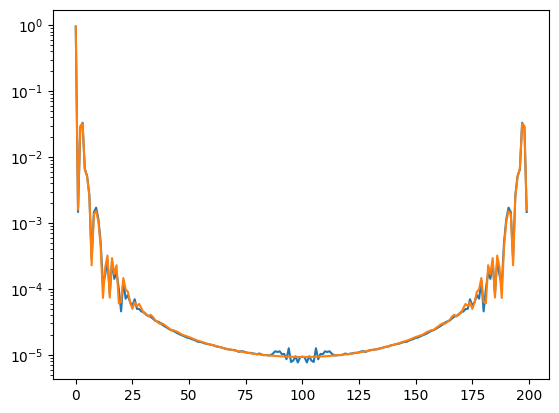

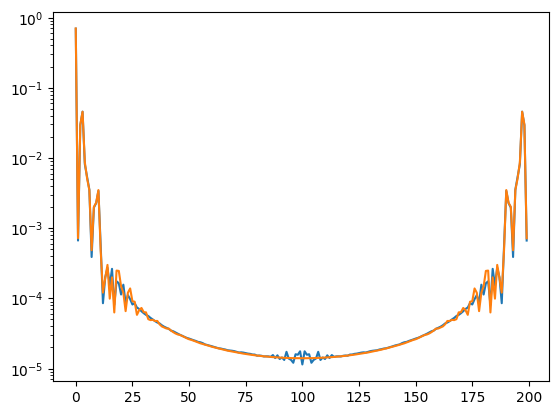

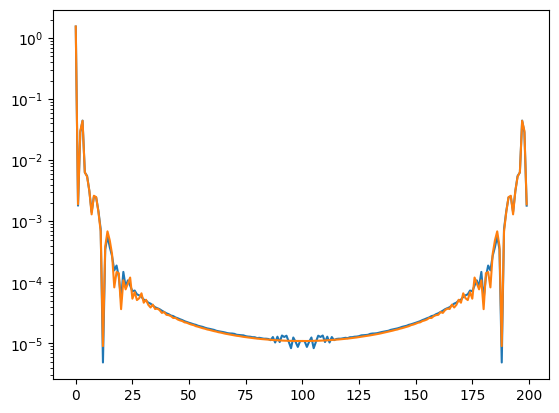

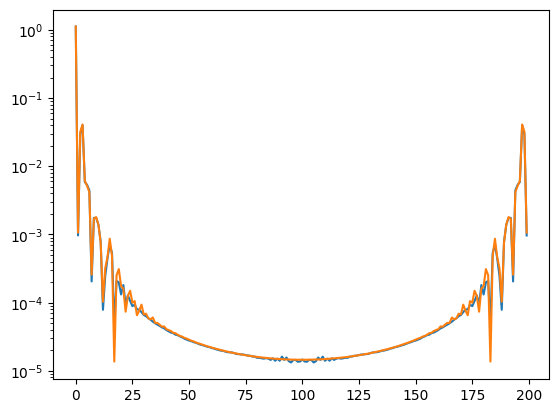

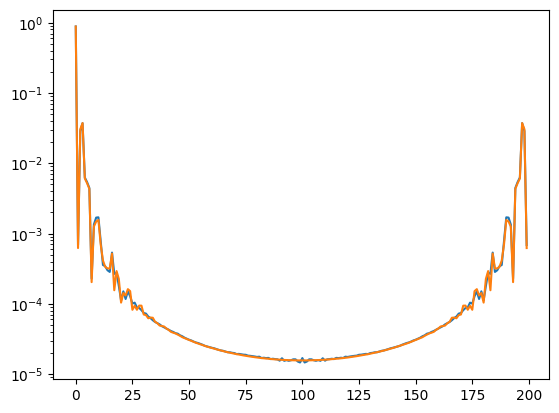

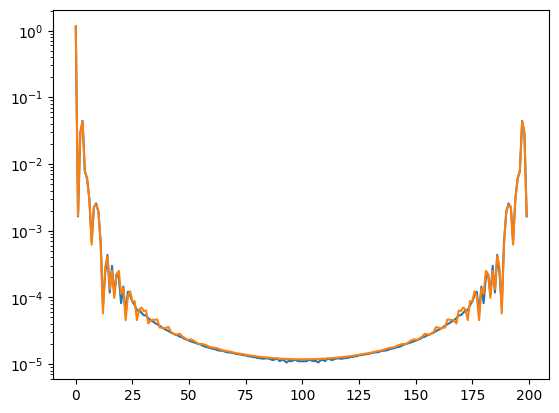

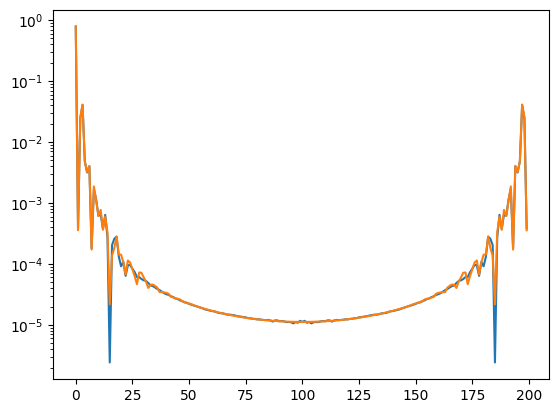

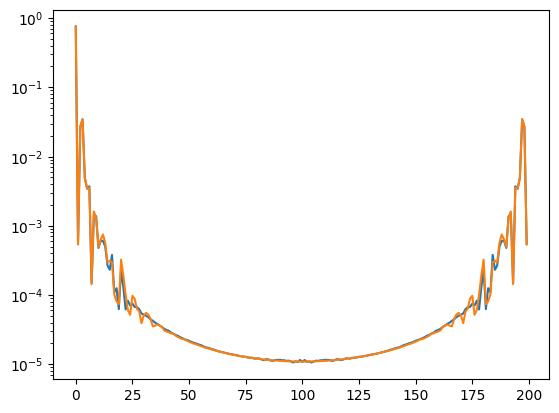

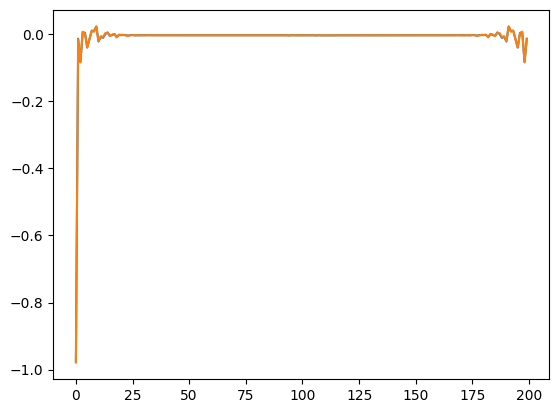

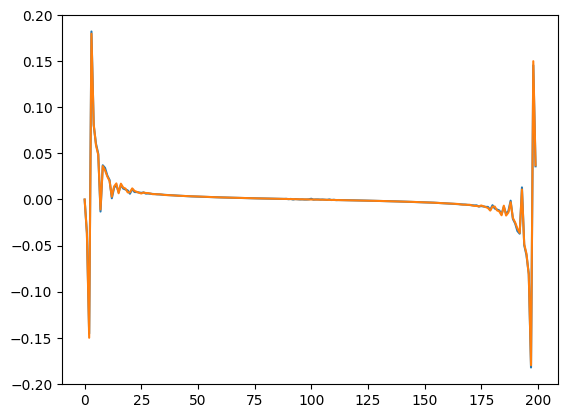

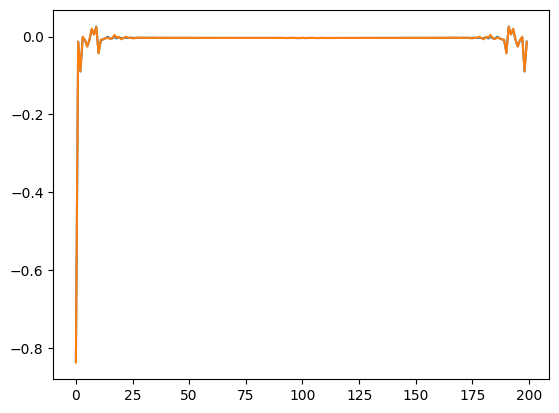

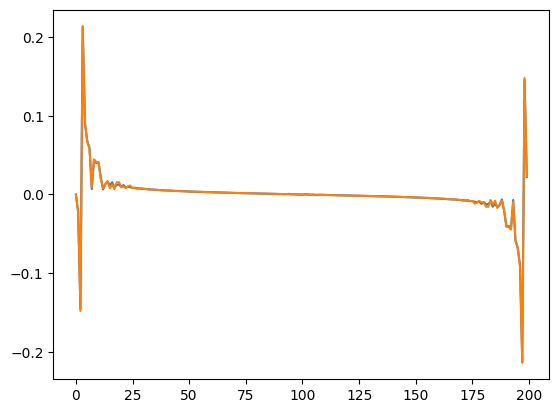

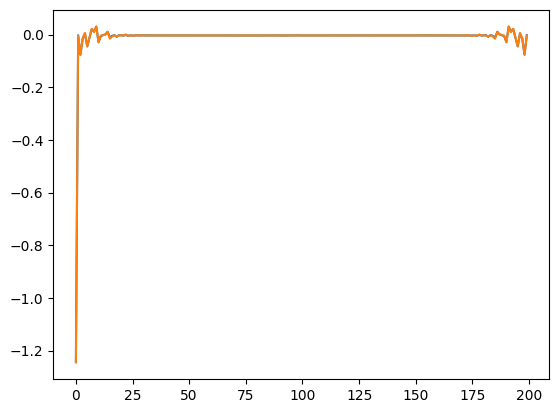

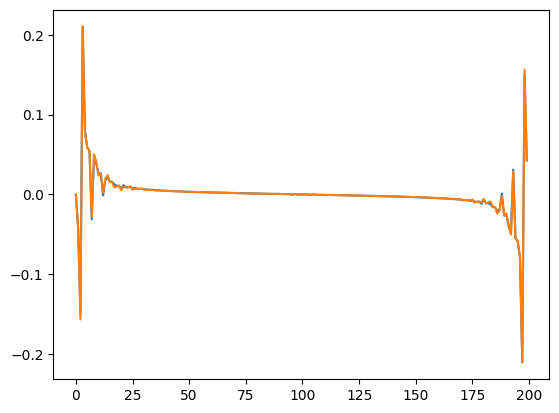

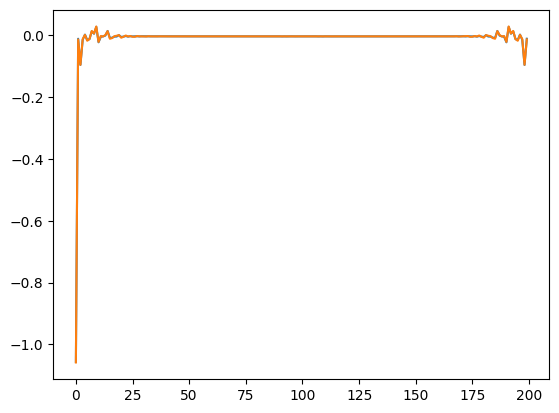

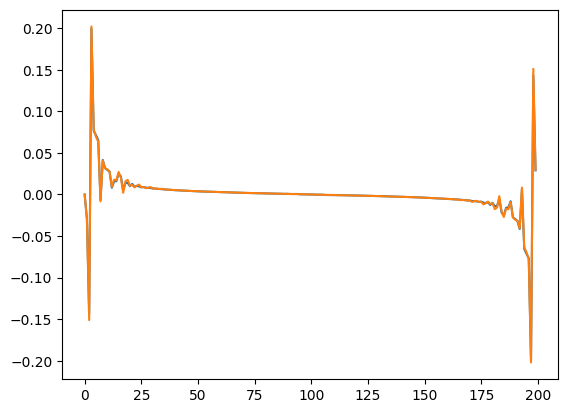

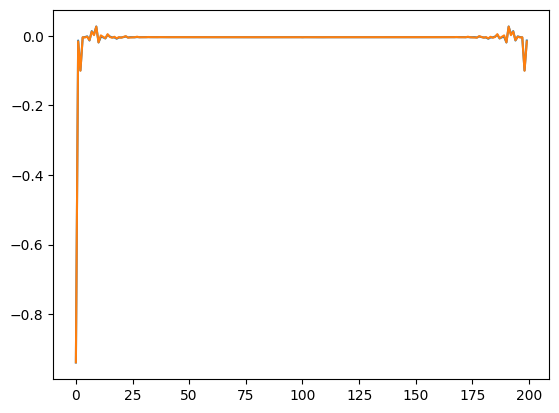

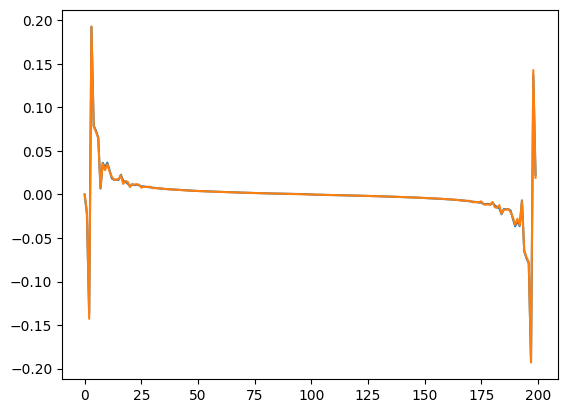

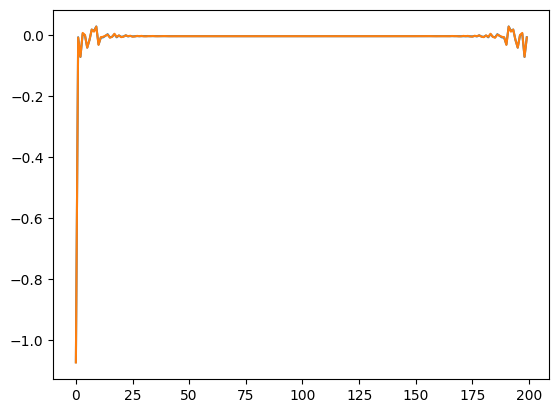

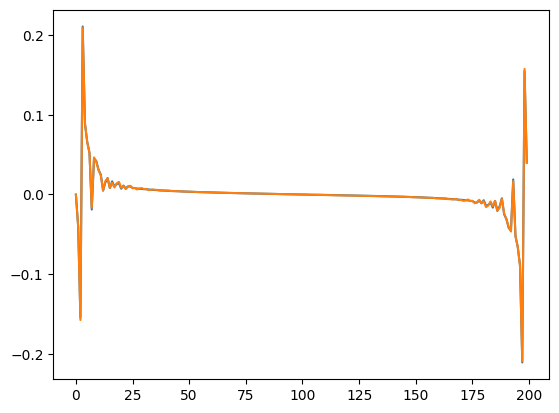

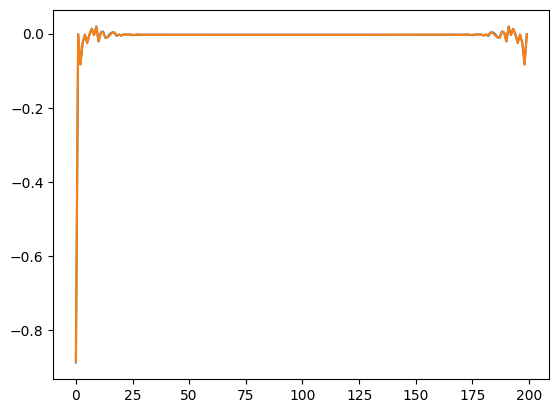

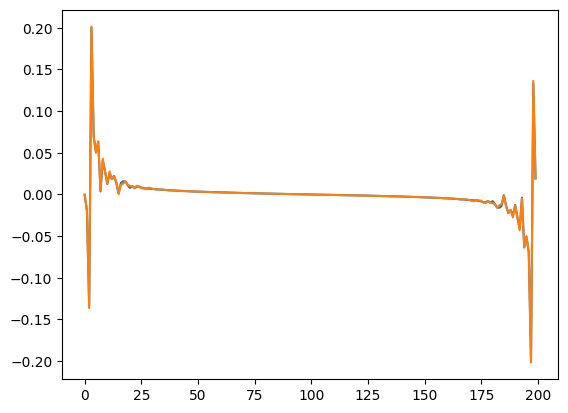

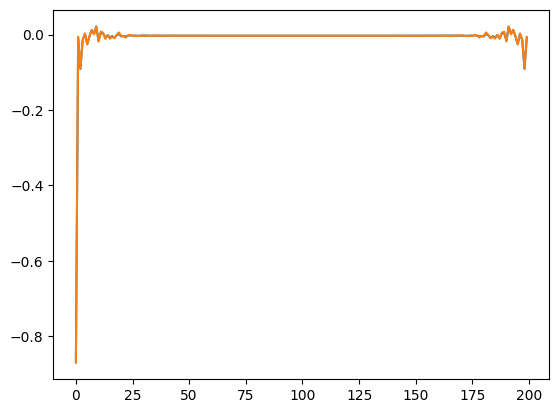

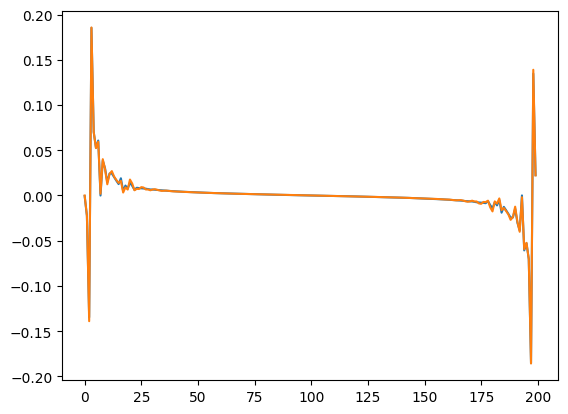

In [ ]:
idx=np.random.randint(0,ndata)
print(h_eff.shape)
for i in range(h_eff_fft.shape[-1]):
    
    plt.plot(h_eff_fft_reconstruction[idx,0,:,i]**2+h_eff_fft_reconstruction[idx,1,:,i]**2)
    plt.plot(h_eff_fft[idx,0,:,i]**2+h_eff_fft[idx,1,:,i]**2)
    plt.semilogy()
    plt.show()
    
for i in range(h_eff_fft.shape[-1]):
    
    plt.plot(h_eff_fft_reconstruction[idx,0,:,i])
    plt.plot(h_eff_fft[idx,0,:,i])
    plt.show()

    plt.plot(h_eff_fft_reconstruction[idx,1,:,i])
    plt.plot(h_eff_fft[idx,1,:,i])
    plt.show()



#### (Optional) Fourier filter

In [ ]:
h_eff_fft_reconstruction_filter=h_eff_fft_reconstruction.copy()
h_eff_fft_reconstruction_filter[:,:,40:-40]=0.
h_eff_reconstruction_filter=ifft(h_eff_fft_reconstruction_filter[:,0]+1j*h_eff_fft_reconstruction_filter[:,1],norm='forward',axis=1)


#### Test in the time space

/home/ecosta/miniconda3/envs/dft_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ecosta/miniconda3/envs/dft_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


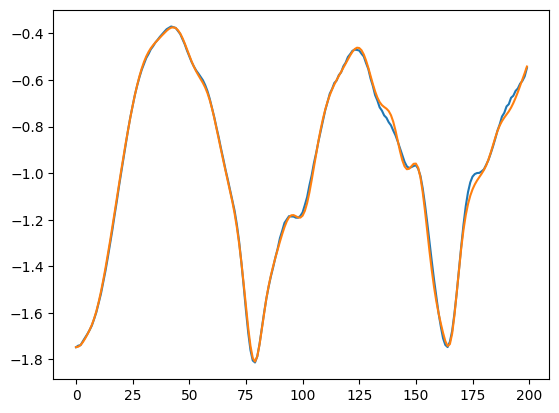

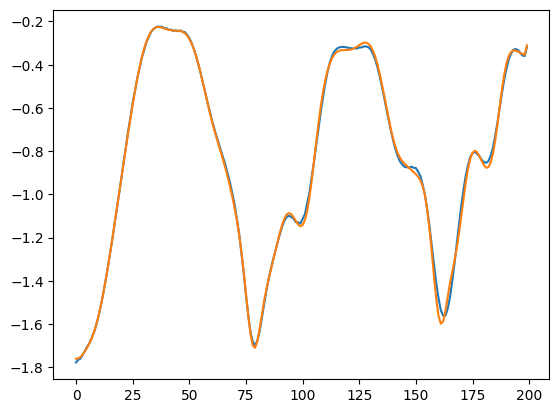

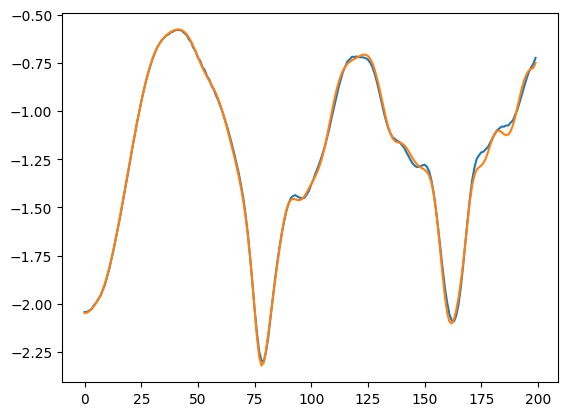

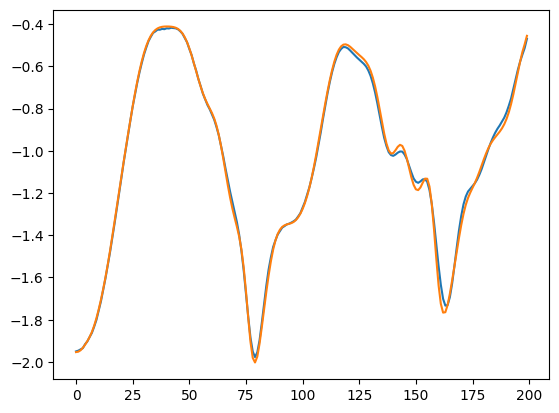

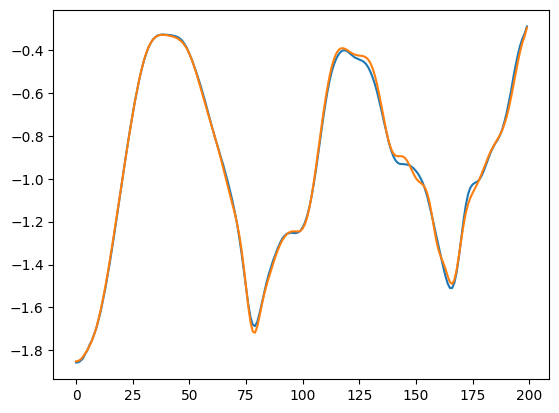

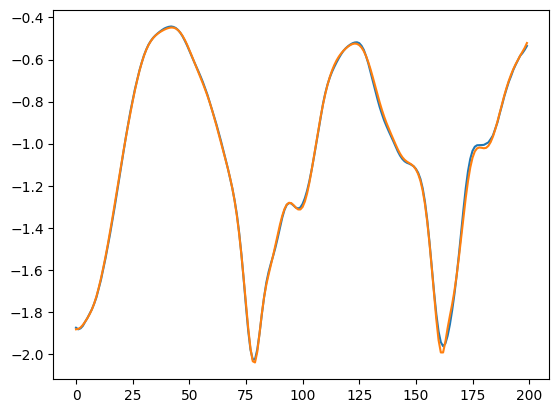

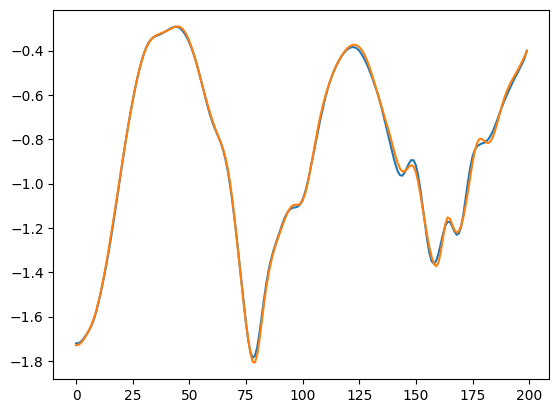

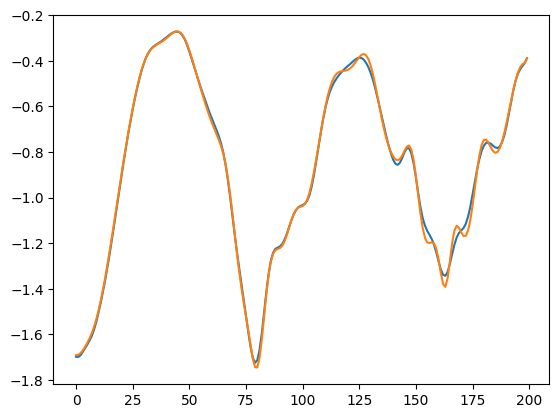

In [ ]:

h_eff_reconstruction=ifft(h_eff_fft_reconstruction[:,0]+1j*h_eff_fft_reconstruction[:,1],norm='forward',axis=1)


h_eff=ifft(h_eff_fft[:,0]+1j*h_eff_fft[:,1],norm='forward',axis=1)



for i in range(h_eff.shape[-1]):
    plt.plot(h_eff_reconstruction[idx,:,i])
   # plt.plot(h_eff_reconstruction_filter[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    



#### (Optional) Reconstruction filter

In [ ]:

for i in range(h_eff.shape[-1]):
    #plt.plot(h_eff_reconstruction[idx,:,i])
    plt.plot(h_eff_reconstruction_filter[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    

### Test the prediction of the model in the Fourier encoding

#### Imports

In [1]:
import torch
import numpy as np
from numpy.fft import fft,ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List


In [2]:
data=np.load('data/dataset_h_eff/train_dataset_fourier_format_240301_ndata_60000.npz')

h=data['h']
potential=data['potential']

new_h=h[:,:,:101]
new_potential=potential[:,:,:101]

np.savez('data/dataset_h_eff/train_dataset_fourier_format_half_spectrum_ndata_60000.npz',h=new_h,potential=new_potential)



#### Parameters

In [ ]:
data_fourier=np.load('data/dataset_h_eff/train_dataset_fourier_format_240229_ndata_20000.npz')

nbatch=100

h_fft=data_fourier['h']
h_eff_fft=data_fourier['potential']

h_fft_torch=torch.tensor(h_fft[:nbatch,:,:101])

model=torch.load('model_rep/kohm_sham/cnn_field2field/REDENT2D_fourier_field2field_time_steps_200_tf_20_240327_dataset_60k_[80, 80, 80]_hc_[15, 5]_ks_1_ps_3_nconv_1_nblock',map_location='cpu')
model.eval()



In [4]:
output=model(h_fft_torch).detach().numpy()

symmetric_part=np.flip(output[:,:,1:-1],axis=-2)

h_eff_fft_reconstruction=np.append(output,symmetric_part,axis=-2)
print(h_eff_fft_reconstruction.shape)

h_eff_fft_reconstruction[:,1,100:]=-1*h_eff_fft_reconstruction[:,1,100:]


(100, 2, 200, 8)


#### Test in the fourier space

(20000, 2, 200, 8)


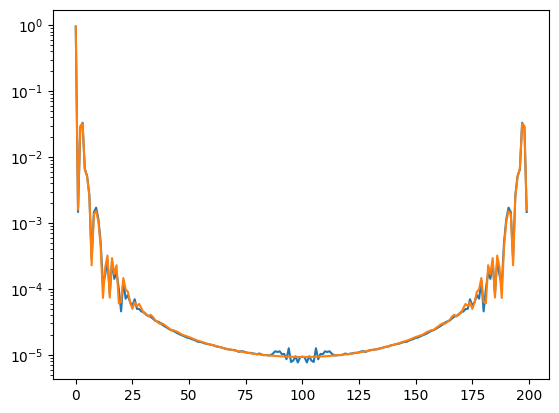

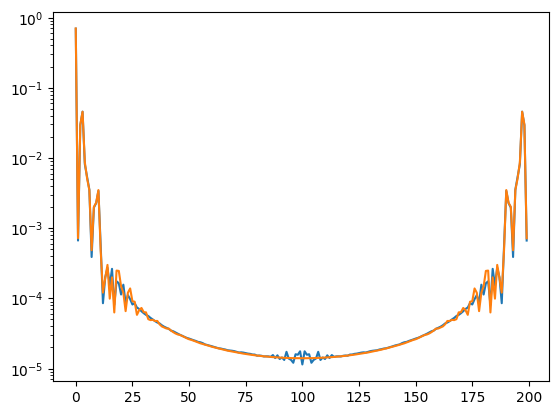

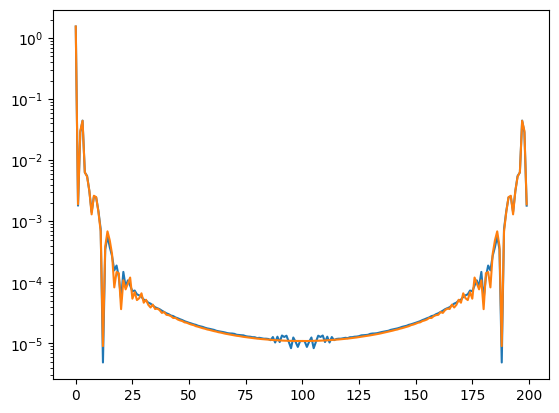

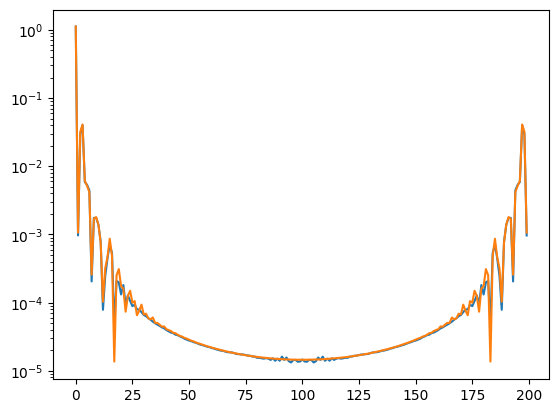

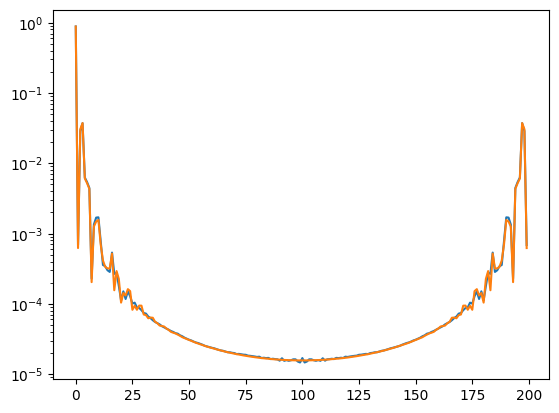

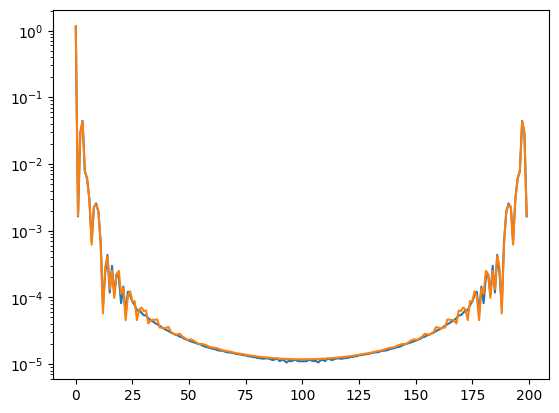

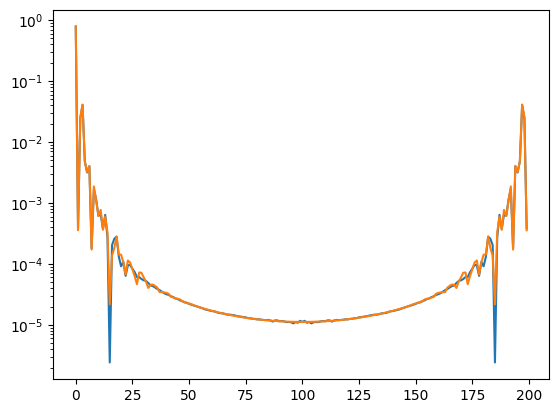

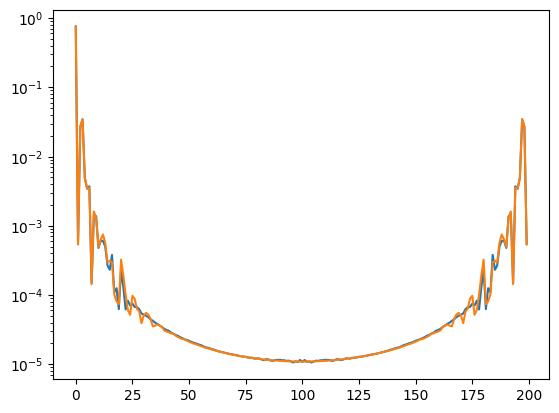

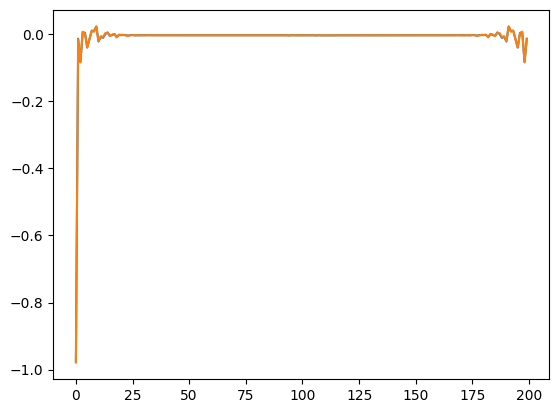

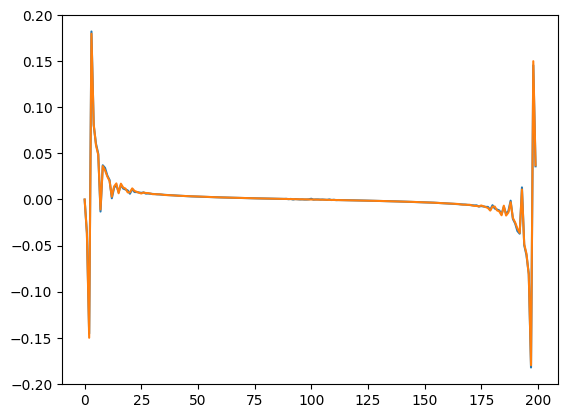

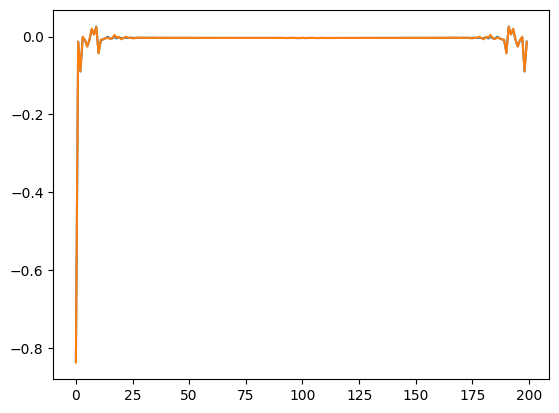

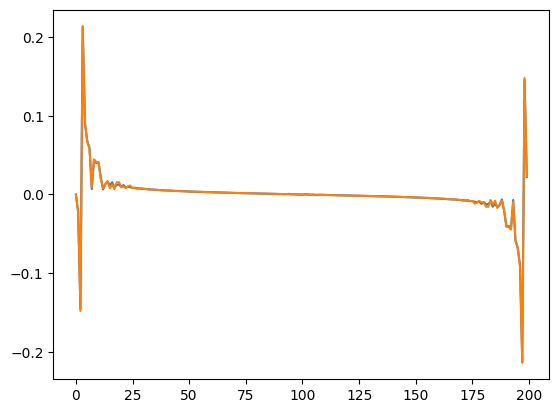

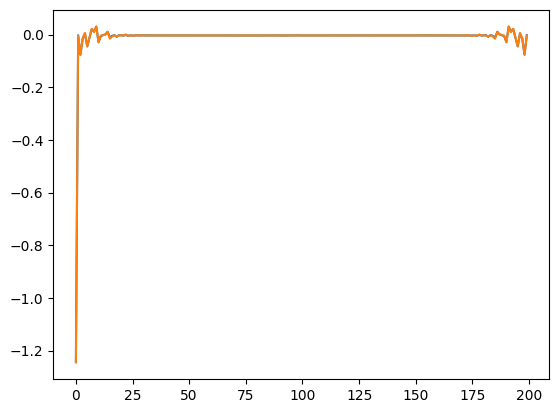

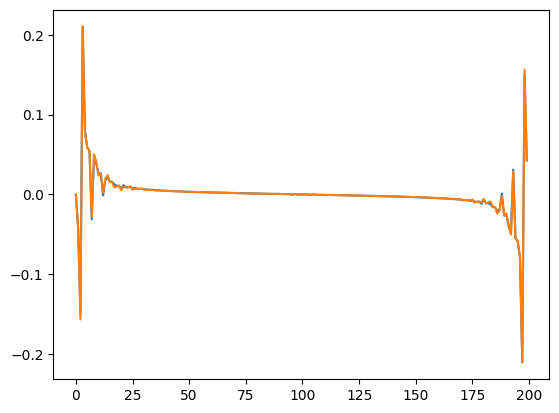

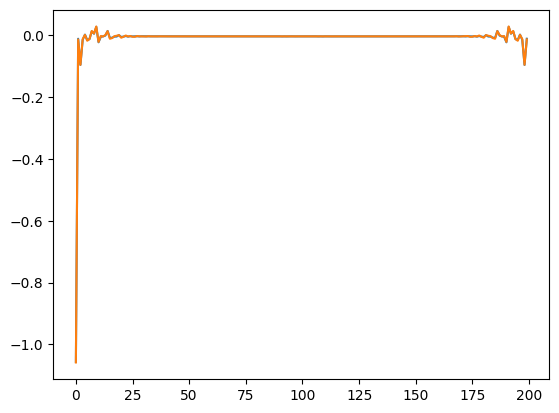

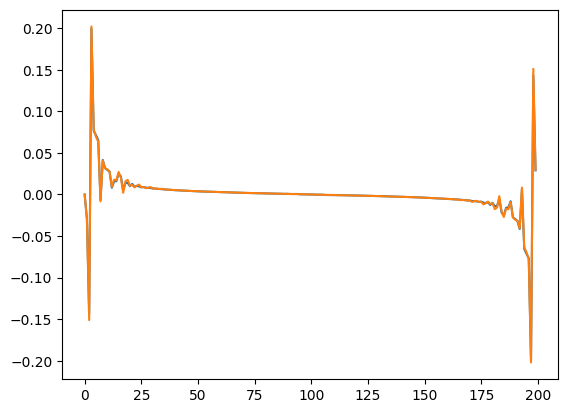

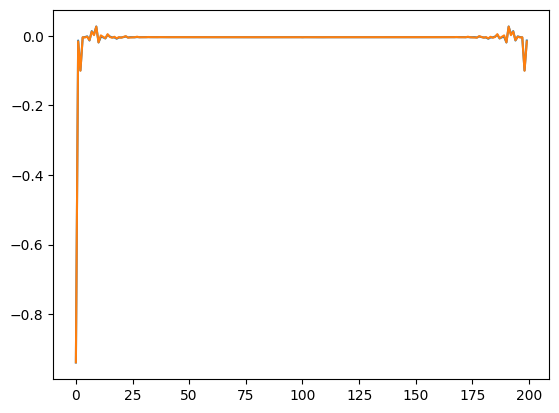

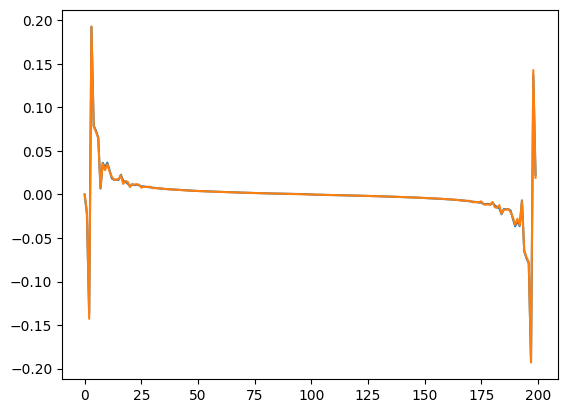

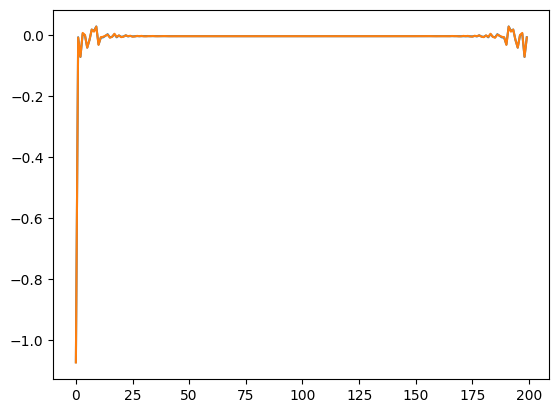

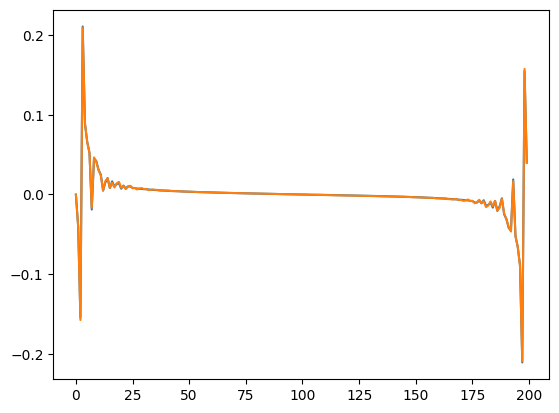

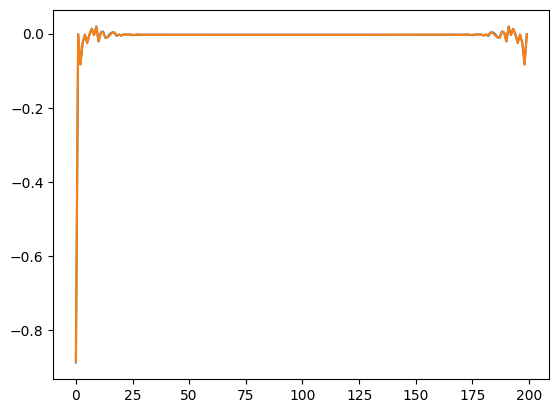

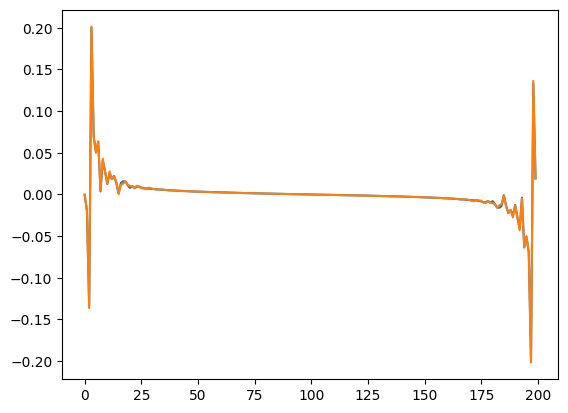

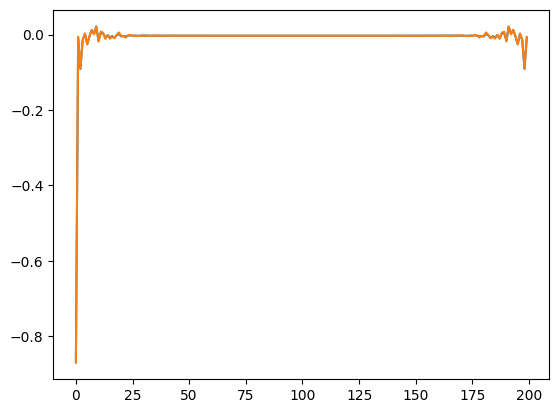

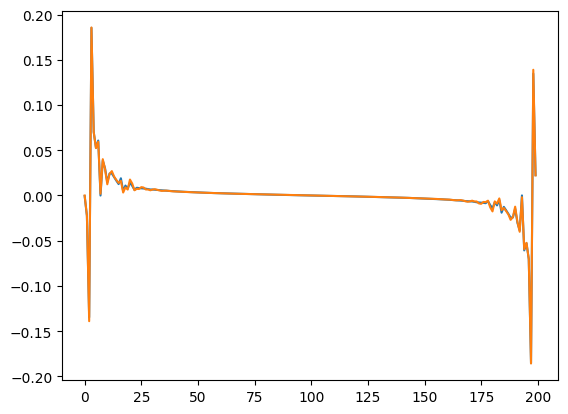

In [5]:
idx=np.random.randint(0,nbatch)
print(h_eff_fft.shape)
for i in range(h_eff_fft.shape[-1]):
    
    plt.plot(h_eff_fft_reconstruction[idx,0,:,i]**2+h_eff_fft_reconstruction[idx,1,:,i]**2)
    plt.plot(h_eff_fft[idx,0,:,i]**2+h_eff_fft[idx,1,:,i]**2)
    plt.semilogy()
    plt.show()
    
for i in range(h_eff_fft.shape[-1]):
    
    plt.plot(h_eff_fft_reconstruction[idx,0,:,i])
    plt.plot(h_eff_fft[idx,0,:,i])
    plt.show()

    plt.plot(h_eff_fft_reconstruction[idx,1,:,i])
    plt.plot(h_eff_fft[idx,1,:,i])
    plt.show()



#### (Optional) Fourier filter

In [13]:
h_eff_fft_reconstruction_filter=h_eff_fft_reconstruction.copy()
h_eff_fft_reconstruction_filter[:,:,40:-40]=0.
h_eff_reconstruction_filter=ifft(h_eff_fft_reconstruction_filter[:,0]+1j*h_eff_fft_reconstruction_filter[:,1],norm='forward',axis=1)


#### Test in the time space

/home/ecosta/miniconda3/envs/dft_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ecosta/miniconda3/envs/dft_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


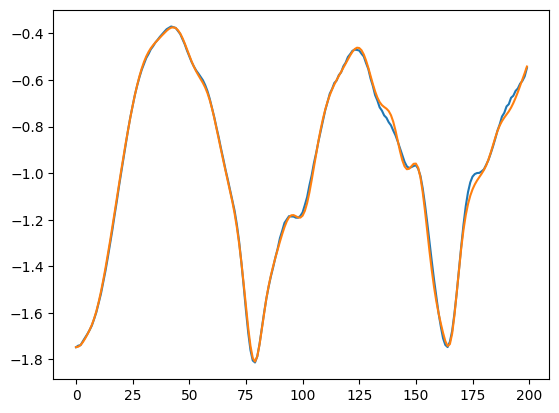

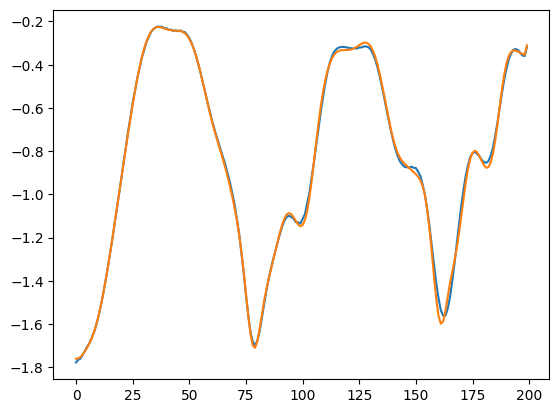

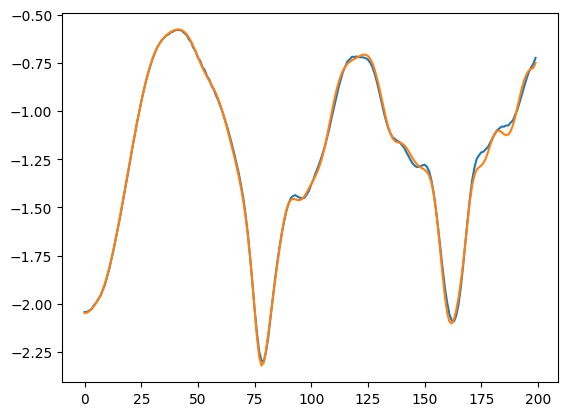

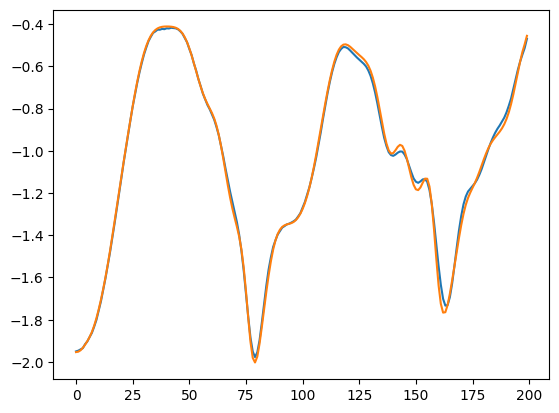

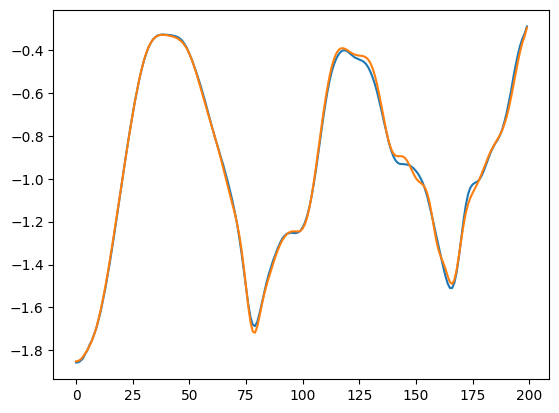

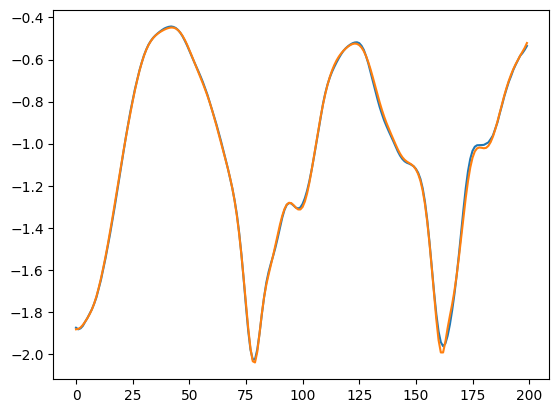

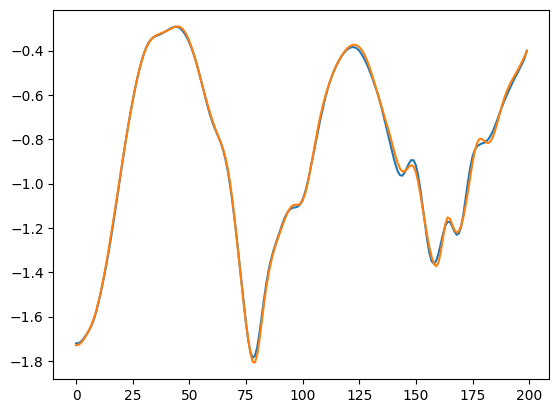

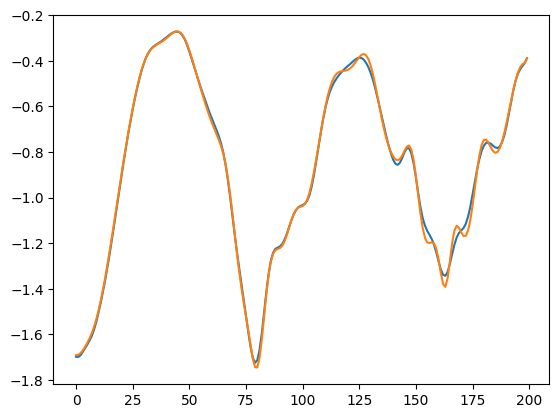

In [6]:

h_eff_reconstruction=ifft(h_eff_fft_reconstruction[:,0]+1j*h_eff_fft_reconstruction[:,1],norm='forward',axis=1)


h_eff=ifft(h_eff_fft[:,0]+1j*h_eff_fft[:,1],norm='forward',axis=1)



for i in range(h_eff.shape[-1]):
    plt.plot(h_eff_reconstruction[idx,:,i])
   # plt.plot(h_eff_reconstruction_filter[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    



#### (Optional) Reconstruction filter

In [ ]:

for i in range(h_eff.shape[-1]):
    #plt.plot(h_eff_reconstruction[idx,:,i])
    plt.plot(h_eff_reconstruction_filter[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    

### Test the prediction of the CausalCNN in the time to time problem fixing the Initial State

#### Imports

In [1]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from matplotlib.ticker import LogLocator

#### Data

In [9]:
data = np.load("data/dataset_h_eff/dataset_TDCNN_fixed_initial_state_240424.npz")

h = data["h"]
potential=data['potential']
print(h.shape)
time=np.linspace(0,20,potential.shape[-1])

h_torch=torch.tensor(h[-100:])
potential_torch=torch.tensor(potential[-100:])

# loading the model
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/TDDFTCNN_field2field_time_steps_100_tf_20_240501_dataset_20k_[80, 80, 80, 80]_hc_[5, 7]_ks_2_ps_4_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

(20000, 8, 200)


TDDFTCNNNoMemory(
  (CNNBlock): ConvBlock(
    (block): Sequential(
      (conv_sp -1): Conv2d(1, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t -1): CausalConv2d(80, 80, kernel_size=(1, 7), stride=(1, 1), bias=False)
      (batchnorm_-1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_sp0): Conv2d(80, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t0): CausalConv2d(80, 80, kernel_size=(1, 7), stride=(1, 1), bias=False)
      (batchnorm_0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_0): ReLU()
      (conv_sp1): Conv2d(80, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t1): CausalConv2d(80, 80, kernel_size=(1, 7), stride=(1, 1), bias=False)
      (batchnorm_1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_1): ReLU()
     

#### Testing the NN

In [10]:
potential_ml=model(h_torch).squeeze().detach().numpy()
print(potential_ml.shape)

(100, 8, 200)


Plot the samples

In [ ]:
site=3
idx=np.random.randint(0,100)
for site in range(8):
    plt.plot(potential_ml[idx,site,:])
    plt.plot(potential_torch[idx, site, :].detach().numpy())
    plt.show()

Measures of the error

(8, 200)


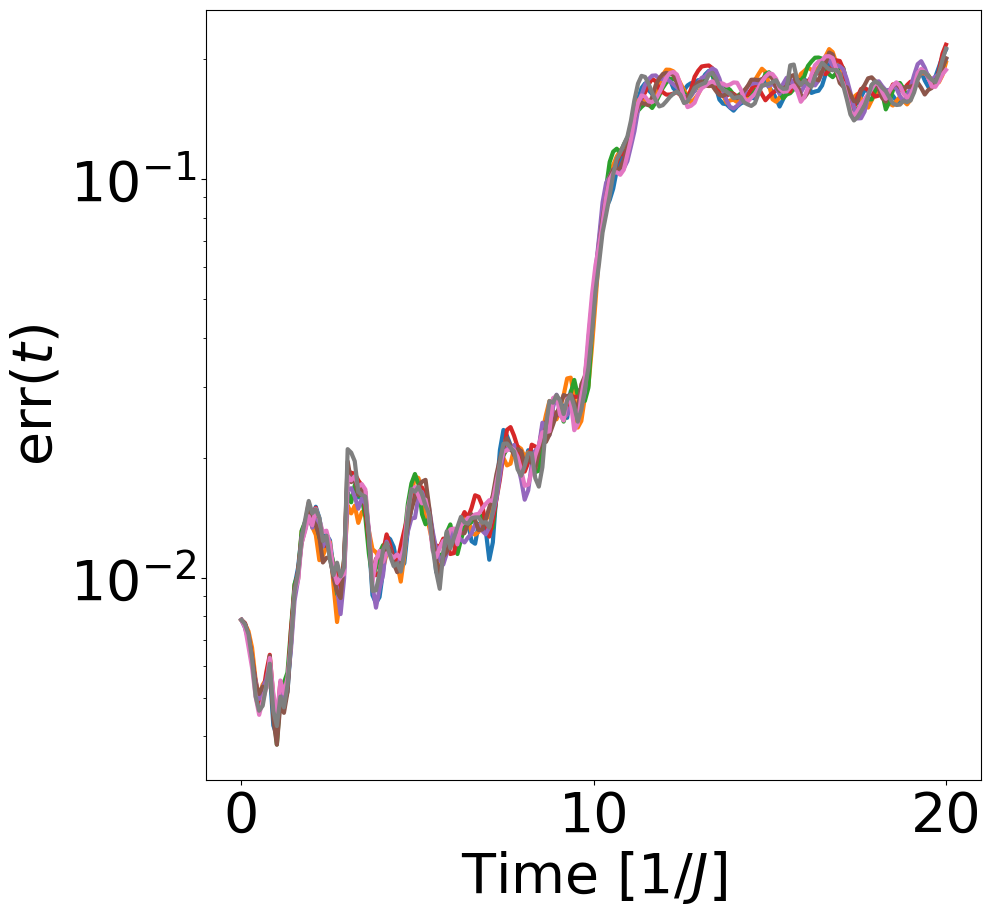

In [12]:


de=np.abs(potential_torch.detach().numpy()-potential_ml)

idx_max=np.argmax(de,axis=0)
print(idx_max.shape)
# for i in range(de.shape[1]):

#     plt.plot(time,potential_ml[0,i,:])
#     plt.plot(time, potential_torch.detach().numpy()[0,i,:])
#     plt.show()

#     plt.plot(time, de[0,i,:])
#     plt.show()

average_err=np.average(de,axis=0)
plt.figure(figsize=(10,10))
for i in range(de.shape[1]):
    plt.plot(time,average_err[i,:],linewidth=3)
plt.semilogy()
plt.xlabel(r'Time $[1/J]$',fontsize=40)
plt.ylabel(r'$\mathrm{err}(t)$',fontsize=40)

plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
plt.gca().yaxis.set_minor_locator(LogLocator(subs="all", numticks=10))
plt.show()

##### Test at different sizes

Data

In [3]:
data = np.load(
    "data/dataset_h_eff/periodic/dataset_periodic_random_rate_03-1_random_amplitude_01-08_fixed_initial_state_nbatch_1_batchsize_100_steps_200_tf_20.0_l_10_240424.npz"
)

h = np.einsum("bti->bit", data["h"])
potential = np.einsum('bti->bit',data["h_eff"])
print(h.shape)
time = np.linspace(0, 20, potential.shape[-1])

h_torch = torch.tensor(h[-100:])
potential_torch = torch.tensor(potential[-100:])

# loading the model
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/TDDFTCNN_field2field_time_steps_100_tf_20_240426_dataset_200k_[80, 80, 80, 80]_hc_[5, 15]_ks_2_ps_4_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

(100, 10, 200)


TDDFTCNNNoMemory(
  (CNNBlock): ConvBlock(
    (block): Sequential(
      (conv_sp -1): Conv2d(1, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t -1): CausalConv2d(80, 80, kernel_size=(1, 15), stride=(1, 1), bias=False)
      (batchnorm_-1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_sp0): Conv2d(80, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t0): CausalConv2d(80, 80, kernel_size=(1, 15), stride=(1, 1), bias=False)
      (batchnorm_0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_0): ReLU()
      (conv_sp1): Conv2d(80, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t1): CausalConv2d(80, 80, kernel_size=(1, 15), stride=(1, 1), bias=False)
      (batchnorm_1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_1): ReLU()
  

Test

In [4]:
potential_ml=model(h_torch).squeeze().detach().numpy()
print(potential_ml.shape)

(100, 10, 200)


(10, 200)


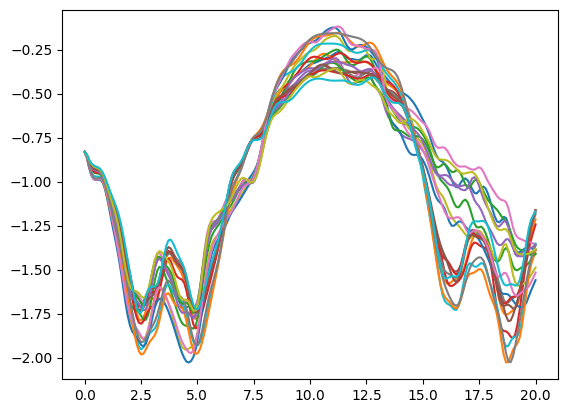

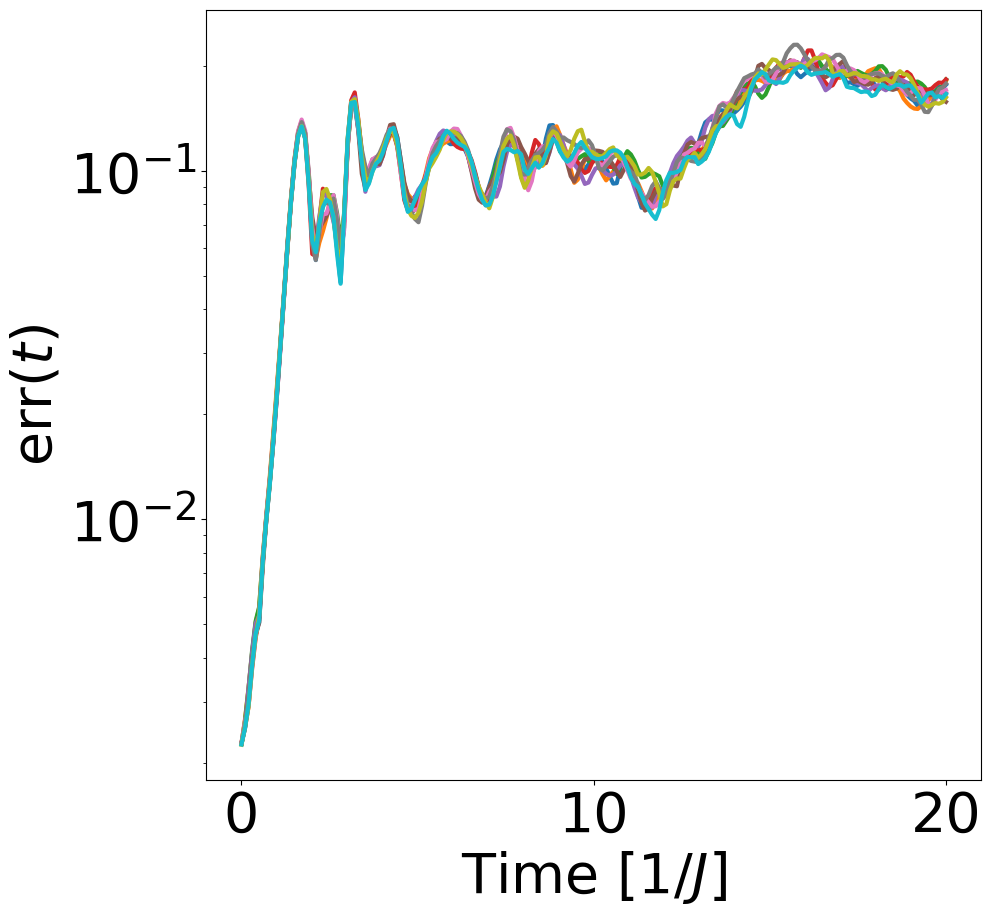

In [26]:
de = np.abs(potential_torch.detach().numpy() - potential_ml)

idx_max = np.argmax(de, axis=0)
print(idx_max.shape)
for i in range(de.shape[1]):

    plt.plot(time,potential_ml[0,i,:])
    plt.plot(time, potential_torch.detach().numpy()[0,i,:])
plt.show()

    
average_err = np.average(de, axis=0)
plt.figure(figsize=(10, 10))
for i in range(de.shape[1]):
    plt.plot(time, average_err[i, :], linewidth=3)
plt.semilogy()
plt.xlabel(r"Time $[1/J]$", fontsize=40)
plt.ylabel(r"$\mathrm{err}(t)$", fontsize=40)

plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
plt.gca().yaxis.set_minor_locator(LogLocator(subs="all", numticks=10))
plt.show()

## DL-effective field and computation via auxiliary system (Fourier Case)

#### Imports

In [7]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

#### Data

In [8]:
data = np.load(
    "data/dataset_h_eff/periodic/dataset_periodic_random_rate_0-1_nbatch_100_batchsize_1000_steps_200_tf_20.0_l_8_240229.npz"
)

maxdata=100

h = data["h"][-maxdata:]
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]

# Loading the model
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/REDENT2D_fourier_field2field_time_steps_200_tf_20_240327_dataset_60k_[80, 80, 80]_hc_[15, 5]_ks_1_ps_3_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

REDENT2D(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(2, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (batch_norm 1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation 1): GELU(approximate='none')
      (conv_1_1): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (batch_norm 1_1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_1_1): GELU(approximate='none')
      (pooling 1): AvgPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0)
    )
    (1): Sequential(
      (conv2): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (activation 2): GELU(approximate='none')
      (conv_2_1): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (activation_2_1): GELU(approximate='none')
      (pool

#### $h_{eff}(t)$ from the DL mapping

In [9]:
h_eff_prediction=field2field_mapping(model=model,h_input=h)


(100, 2, 200, 8)
torch.Size([100, 2, 101, 8])


#### Check the comparison with the exact $h_{eff}(t)$

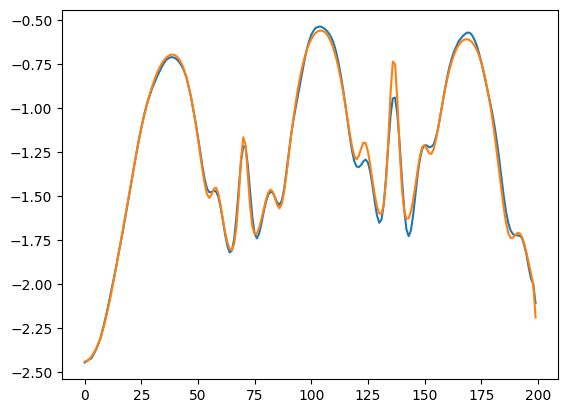

In [11]:
index_sample=np.random.randint(0,maxdata)

idx=4
plt.plot(h_eff_prediction[index_sample,:,idx])
plt.plot(h_eff[index_sample, :, idx])
plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [12]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [13]:
l = 8
steps = 200
tf = 20.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)


# %% Compute the initial ground state configuration


for idx in range(l):
    psi0 = np.zeros(2)
    psi0[0] = np.sqrt((1 + z[index_sample, 0, idx]) / 2)
    psi0[1] = np.sqrt((1 - z[index_sample, 0, idx]) / 2)
    
    if idx==0:
        psi=psi0
    else:
        psi=np.kron(psi,psi0)
        
psi0 = qutip.Qobj(
    psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
)



# Measure observable
obs:List=[]
for i in range(l):
    obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)

print(obs[0],len(obs))

print("\n INITIALIZE THE HAMILTONIAN \n")
# build up the time dependent object for the qutip evolution
hamiltonian = [ham0.qutip_op]
print(h_eff_prediction.shape)
for i in range(l):
    drive_z = Driving(
        h=
            h_eff_prediction[index_sample]
        ,
        idx=i,
        dt=time[1] - time[0],
    )

    hamiltonian.append([obs[i], drive_z.field])

# evolution
output = qutip.sesolve(
    hamiltonian,
    psi0,
    time,
    e_ops=obs
)

z_prediction=np.zeros((time.shape[0],l))
for r in range(l):
    z_prediction[:, r] = output.expect[r]

0.10050251256281408
Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]] 8

 INITIALIZE THE HAMILTONIAN 

(100, 200, 8)


#### Predictions

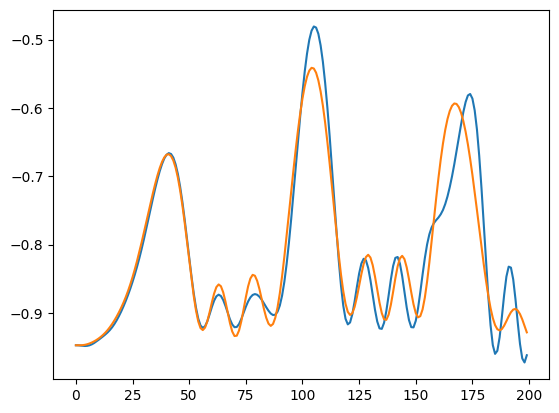

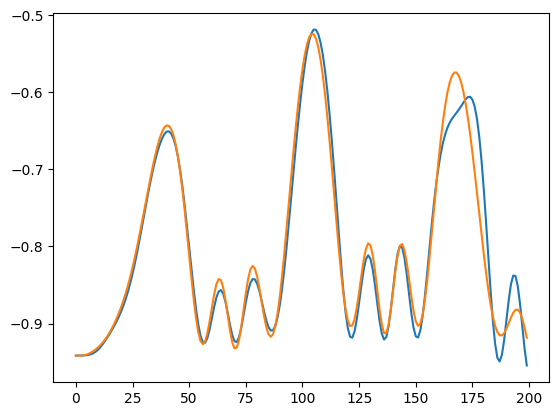

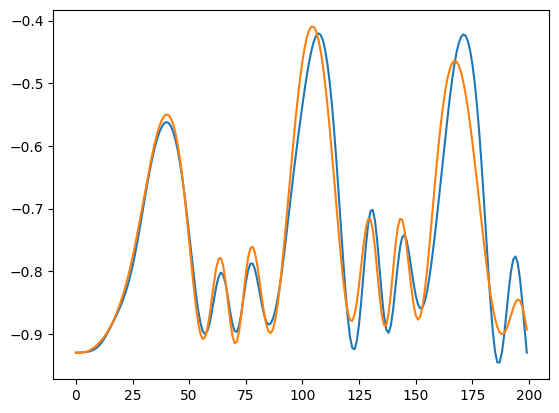

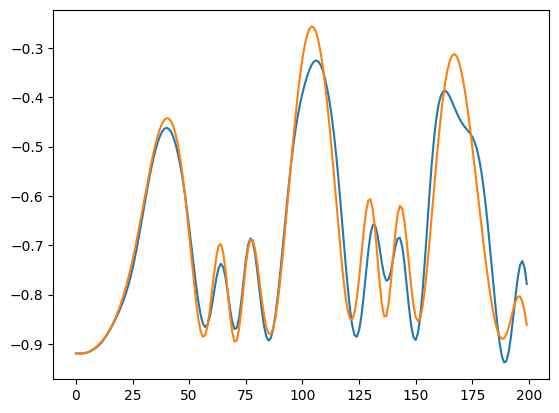

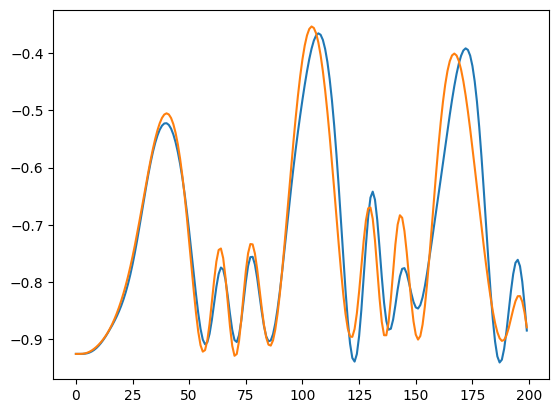

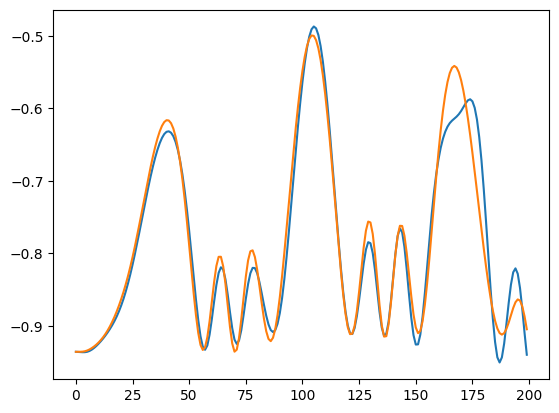

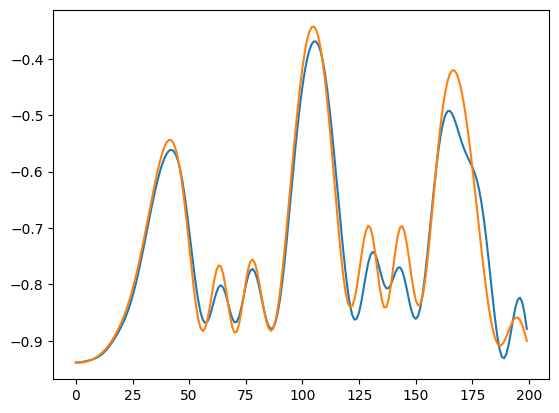

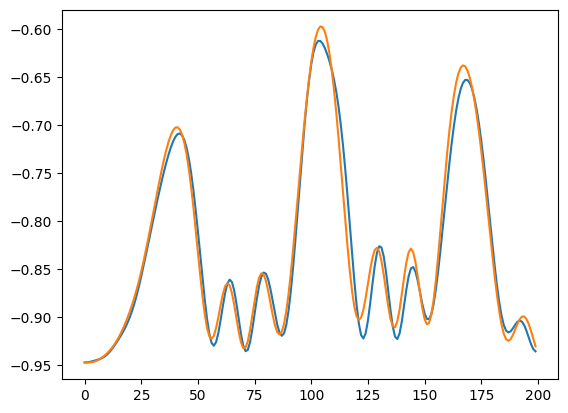

In [16]:
for i in range(l):
    plt.plot(z_prediction[:,i])
    plt.plot(z[index_sample,:,i])
    plt.show()

## DL-effective field and computation via auxiliary system (Causal CNN)

#### Imports

In [8]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

#### Data

In [35]:
data = np.load(
    "data/dataset_h_eff/periodic/dataset_periodic_random_rate_03-1_random_amplitude_01-08_fixed_initial_state_nbatch_1_batchsize_100_steps_200_tf_20.0_l_10_240424.npz"
)

maxdata=100

h = data["h"][-maxdata:]
h=np.einsum('bti->bit',h)
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]

# Loading the model
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/TDDFTCNN_field2field_time_steps_100_tf_20_240426_dataset_200k_[80, 80, 80, 80]_hc_[5, 15]_ks_2_ps_4_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

TDDFTCNNNoMemory(
  (CNNBlock): ConvBlock(
    (block): Sequential(
      (conv_sp -1): Conv2d(1, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t -1): CausalConv2d(80, 80, kernel_size=(1, 15), stride=(1, 1), bias=False)
      (batchnorm_-1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_sp0): Conv2d(80, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t0): CausalConv2d(80, 80, kernel_size=(1, 15), stride=(1, 1), bias=False)
      (batchnorm_0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_0): ReLU()
      (conv_sp1): Conv2d(80, 80, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (conv_t1): CausalConv2d(80, 80, kernel_size=(1, 15), stride=(1, 1), bias=False)
      (batchnorm_1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_1): ReLU()
  

#### $h_{eff}(t)$ from the DL mapping

In [36]:
h_eff_prediction=model(torch.tensor(h)).squeeze().detach().numpy()
h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
print(h_eff_prediction.shape)


(100, 200, 10)


#### Check the comparison with the exact $h_{eff}(t)$

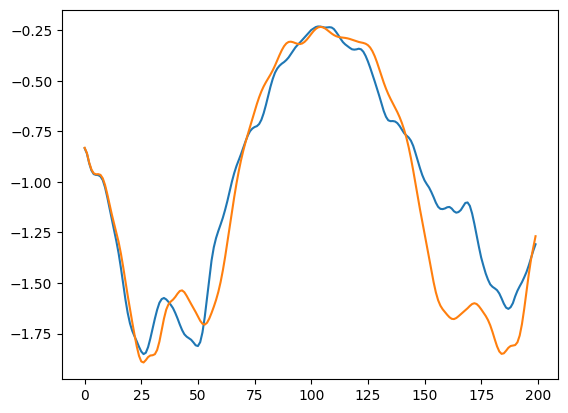

In [37]:
index_sample=np.random.randint(0,maxdata)

idx=4
plt.plot(h_eff_prediction[index_sample,:,idx])
plt.plot(h_eff[index_sample, :, idx])
plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [38]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [39]:
l = 10
steps = 200
tf = 20.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)


# %% Compute the initial ground state configuration


for idx in range(l):
    psi0 = np.zeros(2)
    psi0[0] = np.sqrt((1 + z[index_sample, 0, idx]) / 2)
    psi0[1] = np.sqrt((1 - z[index_sample, 0, idx]) / 2)
    
    if idx==0:
        psi=psi0
    else:
        psi=np.kron(psi,psi0)
        
psi0 = qutip.Qobj(
    psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
)



# Measure observable
obs:List=[]
for i in range(l):
    obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)

print(obs[0],len(obs))

print("\n INITIALIZE THE HAMILTONIAN \n")
# build up the time dependent object for the qutip evolution
hamiltonian = [ham0.qutip_op]
print(h_eff_prediction.shape)
for i in range(l):
    drive_z = Driving(
        h=
            h_eff_prediction[index_sample]
        ,
        idx=i,
        dt=time[1] - time[0],
    )

    hamiltonian.append([obs[i], drive_z.field])

# evolution
output = qutip.sesolve(
    hamiltonian,
    psi0,
    time,
    e_ops=obs
)

z_prediction=np.zeros((time.shape[0],l))
for r in range(l):
    z_prediction[:, r] = output.expect[r]

0.10050251256281408
Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (1024, 1024), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]] 10

 INITIALIZE THE HAMILTONIAN 

(100, 200, 10)


#### Predictions

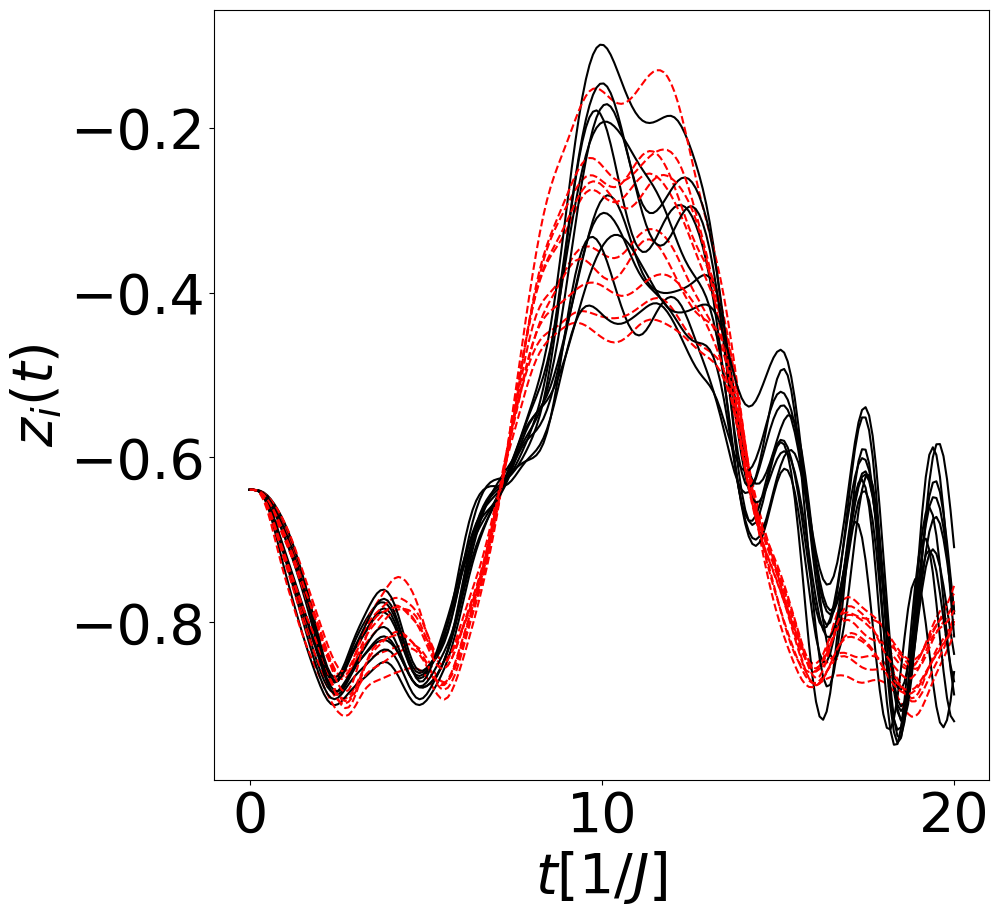

In [40]:
plt.figure(figsize=(10,10))
for i in range(l):
    plt.plot(time,z_prediction[:,i],color='black')
    plt.plot(time,z[index_sample,:,i],linestyle='--',color='red')
plt.ylabel(r'$z_i(t)$',fontsize=40)
plt.xlabel(r'$t[1/J]$',fontsize=40)

plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
plt.show()

## DL-effective field and computation via auxiliary system (LSTM)

#### Imports

In [1]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

#### Data

In [26]:
data = np.load(
    "data/dataset_h_eff/periodic/dataset_periodic_random_rate_03-1_random_amplitude_01-08_fixed_initial_state_nbatch_1_batchsize_100000_steps_400_tf_40.0_l_8_240509.npz"
)

maxdata=100

h = data["h"][-maxdata:]
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]

# Loading the model
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/LSTM_field2field_time_steps_200_tf_20_240510_dataset_20k_[200, 200, 200, 200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_10_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

LSTMTDDFT(
  (model): LSTM(8, 200, proj_size=8, num_layers=10, batch_first=True)
  (loss): MSELoss()
)

#### $h_{eff}(t)$ from the DL mapping

In [27]:
h_eff_prediction,_=model(torch.tensor(h))
h_eff_prediction = h_eff_prediction.detach().numpy()
# h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
print(h_eff_prediction.shape)

(100, 400, 8)


#### Check the comparison with the exact $h_{eff}(t)$

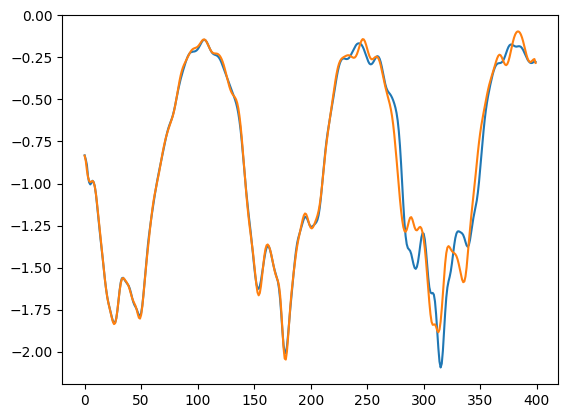

In [51]:
index_sample=np.random.randint(0,maxdata)

idx=4
plt.plot(h_eff_prediction[index_sample,:,idx])
plt.plot(h_eff[index_sample, :, idx])
plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [28]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [31]:
l =8
steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)


# %% Compute the initial ground state configuration


for idx in range(l):
    psi0 = np.zeros(2)
    psi0[0] = np.sqrt((1 + z[index_sample, 0, idx]) / 2)
    psi0[1] = np.sqrt((1 - z[index_sample, 0, idx]) / 2)
    
    if idx==0:
        psi=psi0
    else:
        psi=np.kron(psi,psi0)
        
psi0 = qutip.Qobj(
    psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
)



# Measure observable
obs:List=[]
for i in range(l):
    obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)

print(obs[0],len(obs))

print("\n INITIALIZE THE HAMILTONIAN \n")
# build up the time dependent object for the qutip evolution
hamiltonian = [ham0.qutip_op]
print(h_eff_prediction.shape)
for i in range(l):
    drive_z = Driving(
        h=
            h_eff_prediction[index_sample]
        ,
        idx=i,
        dt=time[1] - time[0],
    )

    hamiltonian.append([obs[i], drive_z.field])

# evolution
output = qutip.sesolve(
    hamiltonian,
    psi0,
    time,
    e_ops=obs
)

z_prediction=np.zeros((time.shape[0],l))
for r in range(l):
    z_prediction[:, r] = output.expect[r]

0.10025062656641603
Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]] 8

 INITIALIZE THE HAMILTONIAN 

(100, 400, 8)


#### Predictions

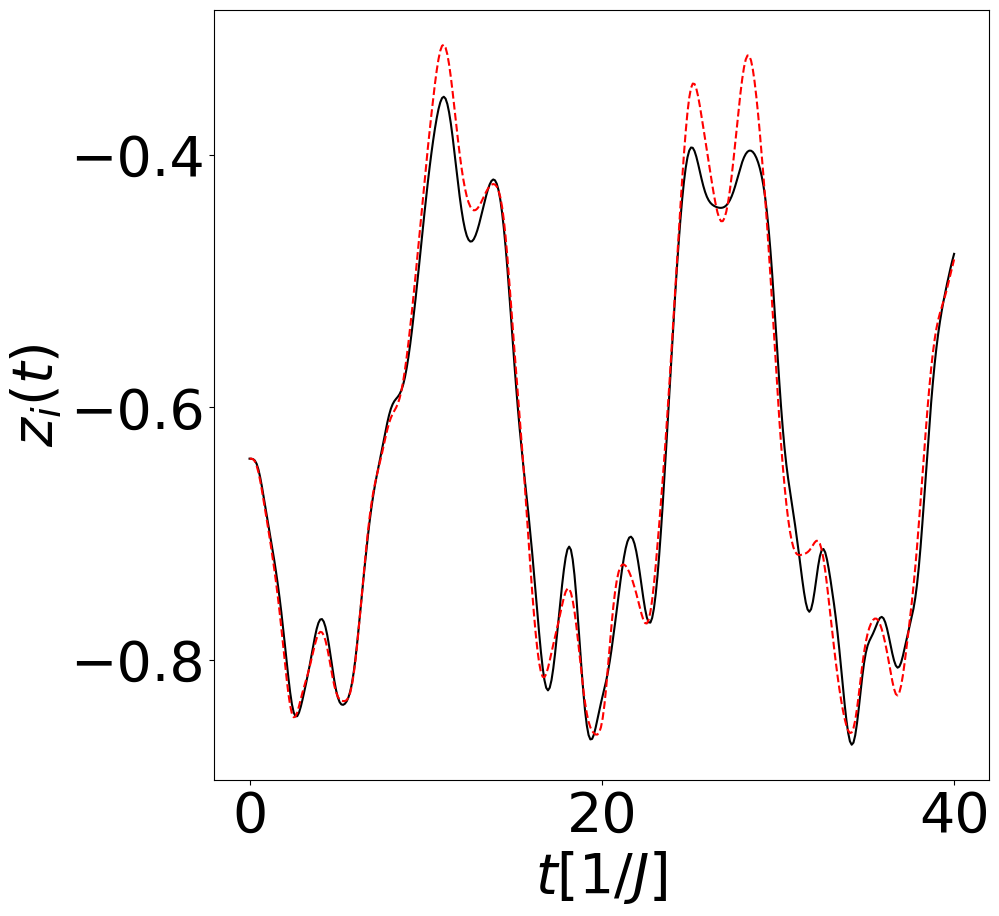

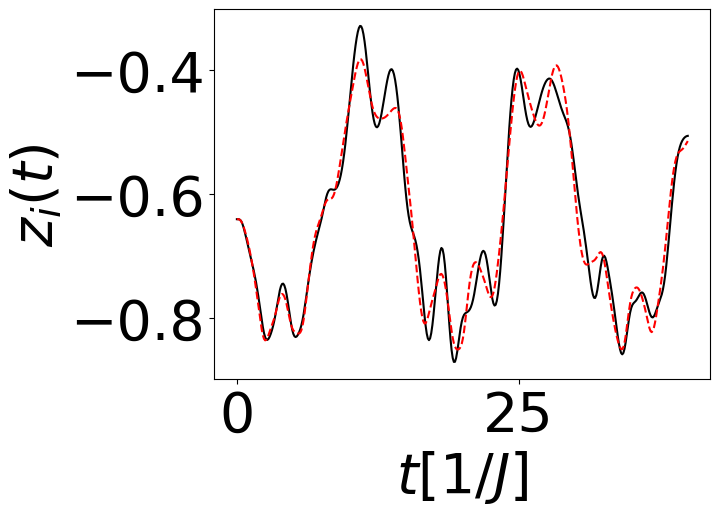

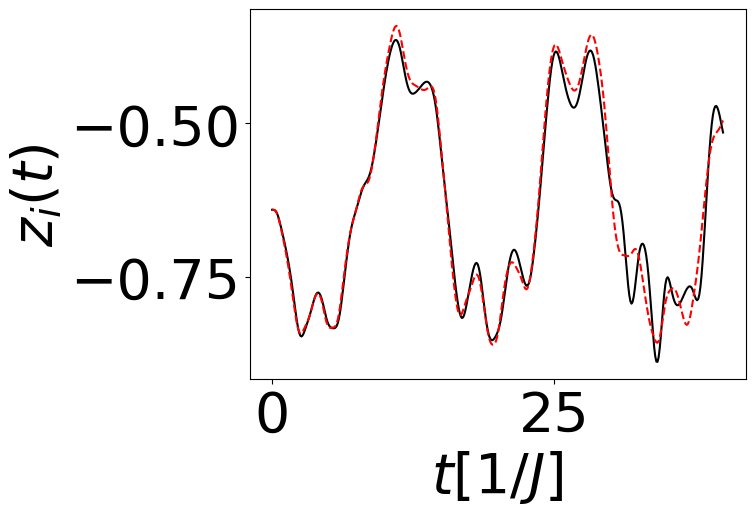

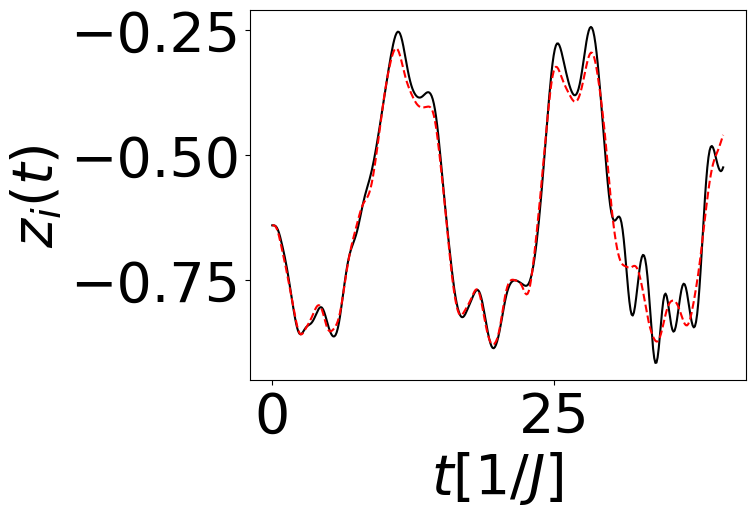

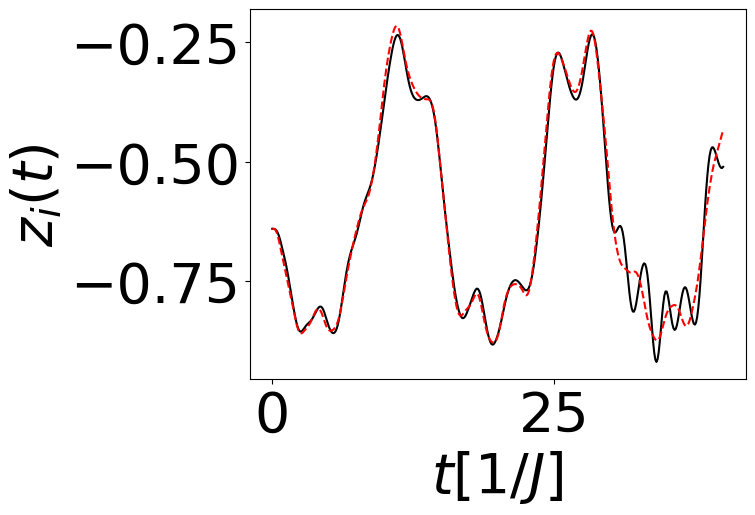

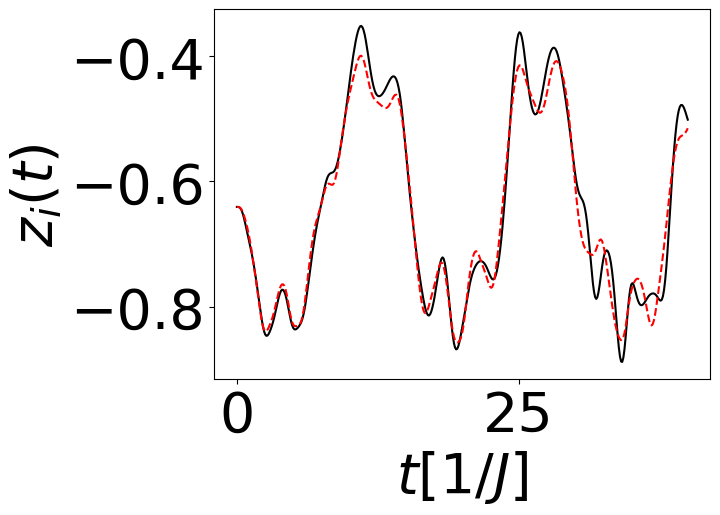

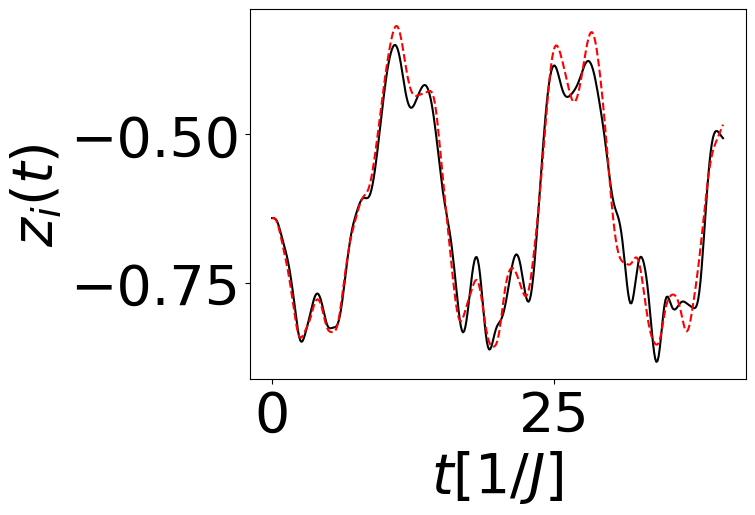

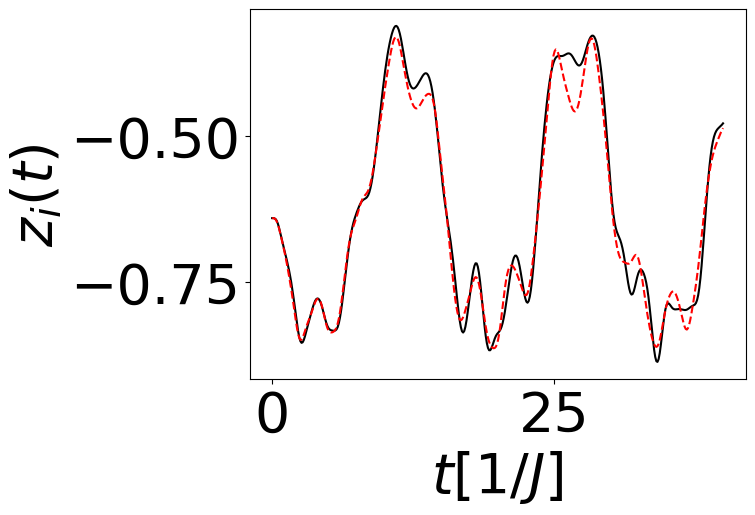

In [32]:
plt.figure(figsize=(10,10))
for i in range(l):
    plt.plot(time,z_prediction[:,i],color='black')
    plt.plot(time,z[index_sample,:,i],linestyle='--',color='red')
    plt.ylabel(r'$z_i(t)$',fontsize=40)
    plt.xlabel(r'$t[1/J]$',fontsize=40)

    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    plt.show()